In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
folder_path = "/content/drive/MyDrive/Data"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #for pretrained models
])


dataset = datasets.ImageFolder(root=folder_path, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
res_net = models.resnet50(pretrained=True)
for param in res_net.parameters():
    param.requires_grad = False
res_net.fc = nn.Linear(res_net.fc.in_features, 2)

viggl_net = models.vgg16(pretrained=True)
for param in viggl_net.parameters():
    param.requires_grad = False
viggl_net.classifier[6] = nn.Linear(viggl_net.classifier[6].in_features, 2)

mobil_net = models.mobilenet_v2(pretrained=True)
for param in mobil_net.parameters():
    param.requires_grad = False
mobil_net.classifier[1] = nn.Linear(mobil_net.classifier[1].in_features, 2)

class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.fc1 = nn.Linear(64*56*56, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

custom_net = CustomCNN()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 194MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


In [6]:
model_list = [res_net, viggl_net, mobil_net, custom_net]

In [7]:
def train_model(model, num_epochs=5, lr=1e-4):
    print(f"Training {model.__class__.__name__}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []
    print("Training...")
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss/total
        train_acc = correct/total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_loss /= total
        val_acc = correct/total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list, model

In [8]:
def evaluate_model(model):
    model.eval()
    all_preds, all_labels = [],[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Fatigue','Non-Fatigue']))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Fatigue','Non-Fatigue'],
                yticklabels=['Fatigue','Non-Fatigue'], cmap="Blues")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


Training ResNet...
Training...
Epoch 1/5 - Train Acc: 0.6071 - Val Acc: 0.7303 - Train Loss: 0.6645 - Val Loss: 0.6016
Epoch 2/5 - Train Acc: 0.7364 - Val Acc: 0.7606 - Train Loss: 0.5966 - Val Loss: 0.5529
Epoch 3/5 - Train Acc: 0.7851 - Val Acc: 0.8030 - Train Loss: 0.5475 - Val Loss: 0.5118
Epoch 4/5 - Train Acc: 0.7955 - Val Acc: 0.8242 - Train Loss: 0.5109 - Val Loss: 0.4863
Epoch 5/5 - Train Acc: 0.8078 - Val Acc: 0.8394 - Train Loss: 0.4906 - Val Loss: 0.4664
Classification Report:
              precision    recall  f1-score   support

     Fatigue       0.77      0.88      0.82       177
 Non-Fatigue       0.83      0.69      0.76       153

    accuracy                           0.79       330
   macro avg       0.80      0.79      0.79       330
weighted avg       0.80      0.79      0.79       330



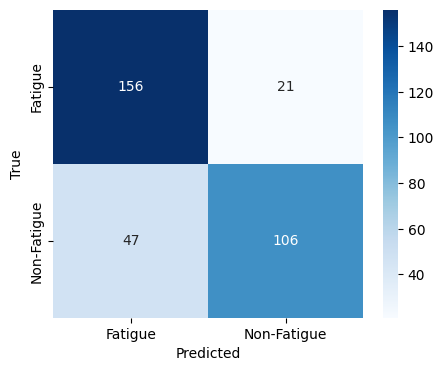

Training VGG...
Training...
Epoch 1/5 - Train Acc: 0.6162 - Val Acc: 0.7485 - Train Loss: 0.6544 - Val Loss: 0.5747
Epoch 2/5 - Train Acc: 0.7097 - Val Acc: 0.7697 - Train Loss: 0.5685 - Val Loss: 0.5283
Epoch 3/5 - Train Acc: 0.7208 - Val Acc: 0.7636 - Train Loss: 0.5446 - Val Loss: 0.5150
Epoch 4/5 - Train Acc: 0.7383 - Val Acc: 0.7636 - Train Loss: 0.5329 - Val Loss: 0.5079
Epoch 5/5 - Train Acc: 0.7409 - Val Acc: 0.7848 - Train Loss: 0.5161 - Val Loss: 0.5001
Classification Report:
              precision    recall  f1-score   support

     Fatigue       0.80      0.80      0.80       177
 Non-Fatigue       0.77      0.76      0.77       153

    accuracy                           0.78       330
   macro avg       0.78      0.78      0.78       330
weighted avg       0.78      0.78      0.78       330



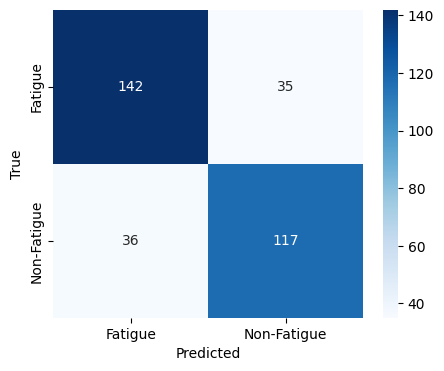

Training MobileNetV2...
Training...
Epoch 1/5 - Train Acc: 0.6494 - Val Acc: 0.7152 - Train Loss: 0.6429 - Val Loss: 0.5921
Epoch 2/5 - Train Acc: 0.7201 - Val Acc: 0.7788 - Train Loss: 0.5802 - Val Loss: 0.5351
Epoch 3/5 - Train Acc: 0.7669 - Val Acc: 0.8000 - Train Loss: 0.5300 - Val Loss: 0.4975
Epoch 4/5 - Train Acc: 0.7773 - Val Acc: 0.7970 - Train Loss: 0.5080 - Val Loss: 0.4732
Epoch 5/5 - Train Acc: 0.7948 - Val Acc: 0.8182 - Train Loss: 0.4809 - Val Loss: 0.4513
Classification Report:
              precision    recall  f1-score   support

     Fatigue       0.83      0.82      0.83       177
 Non-Fatigue       0.80      0.80      0.80       153

    accuracy                           0.82       330
   macro avg       0.81      0.81      0.81       330
weighted avg       0.82      0.82      0.82       330



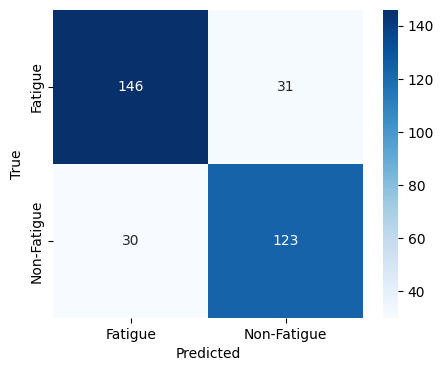

Training CustomCNN...
Training...
Epoch 1/5 - Train Acc: 0.7052 - Val Acc: 0.7697 - Train Loss: 0.6479 - Val Loss: 0.4836
Epoch 2/5 - Train Acc: 0.8071 - Val Acc: 0.8455 - Train Loss: 0.4335 - Val Loss: 0.4052
Epoch 3/5 - Train Acc: 0.8266 - Val Acc: 0.8212 - Train Loss: 0.3842 - Val Loss: 0.4071
Epoch 4/5 - Train Acc: 0.8617 - Val Acc: 0.8152 - Train Loss: 0.3456 - Val Loss: 0.3956
Epoch 5/5 - Train Acc: 0.8779 - Val Acc: 0.8485 - Train Loss: 0.3139 - Val Loss: 0.3681
Classification Report:
              precision    recall  f1-score   support

     Fatigue       0.83      0.87      0.85       177
 Non-Fatigue       0.84      0.80      0.82       153

    accuracy                           0.84       330
   macro avg       0.84      0.83      0.83       330
weighted avg       0.84      0.84      0.84       330



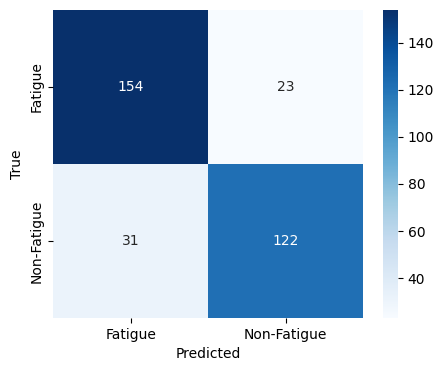

In [9]:
# Train Models, evaluate and Export Them

for model in model_list:
    model.to(device)
    train_acc_list, val_acc_list, train_loss_list, val_loss_list, model = train_model(model,num_epochs=5, lr=1e-4)
    evaluate_model(model)
    torch.save(model, f"{model.__class__.__name__}_model.pth")

In [10]:
# Export Transform
torch.save(transform, 'transform.pth')
# Export Evaluate
torch.save(evaluate_model, 'evaluate_model.pth')


Showing 5 sample predictions for ResNet...


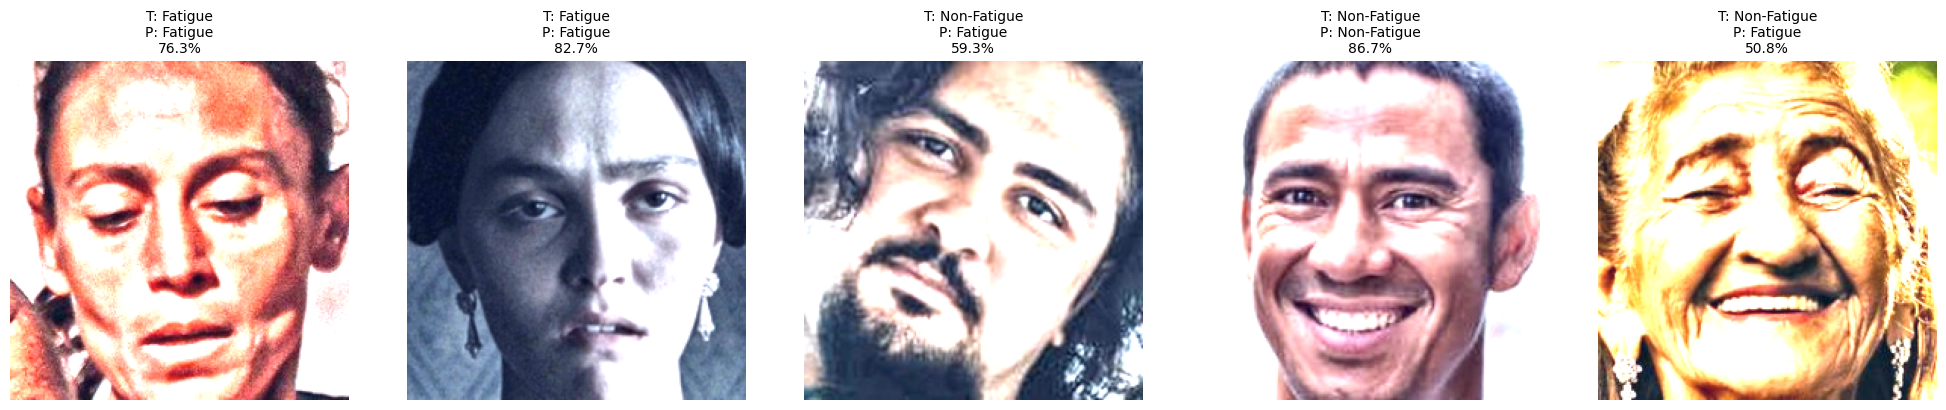

Showing 5 sample predictions for VGG...


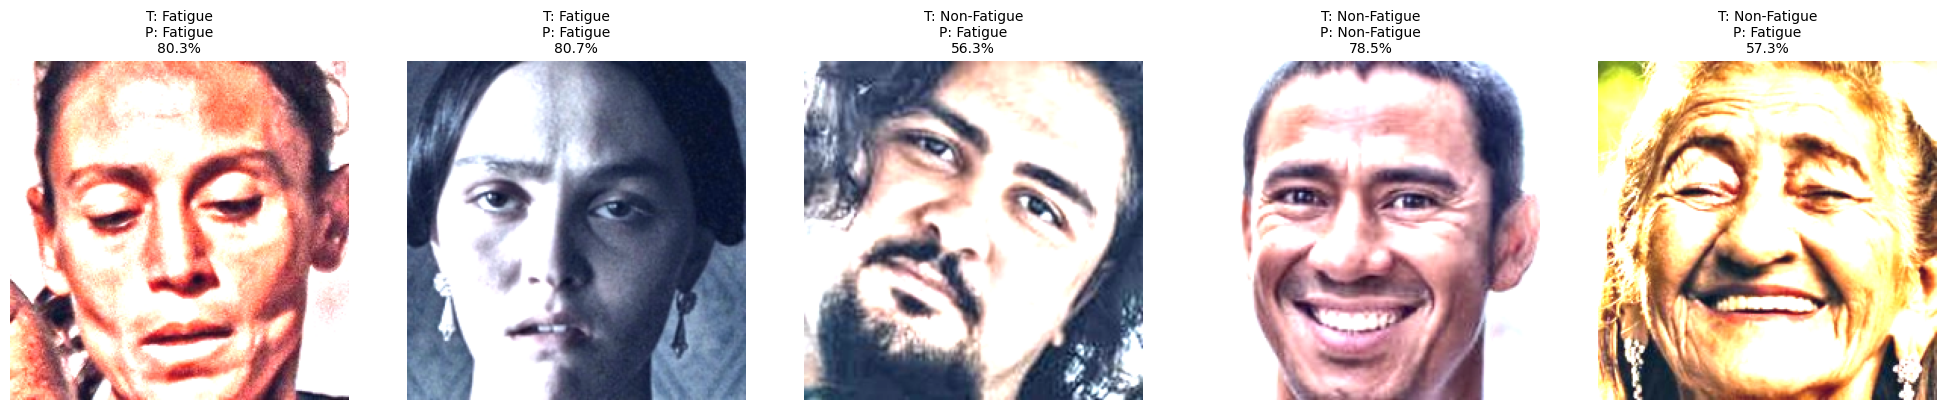

Showing 5 sample predictions for MobileNetV2...


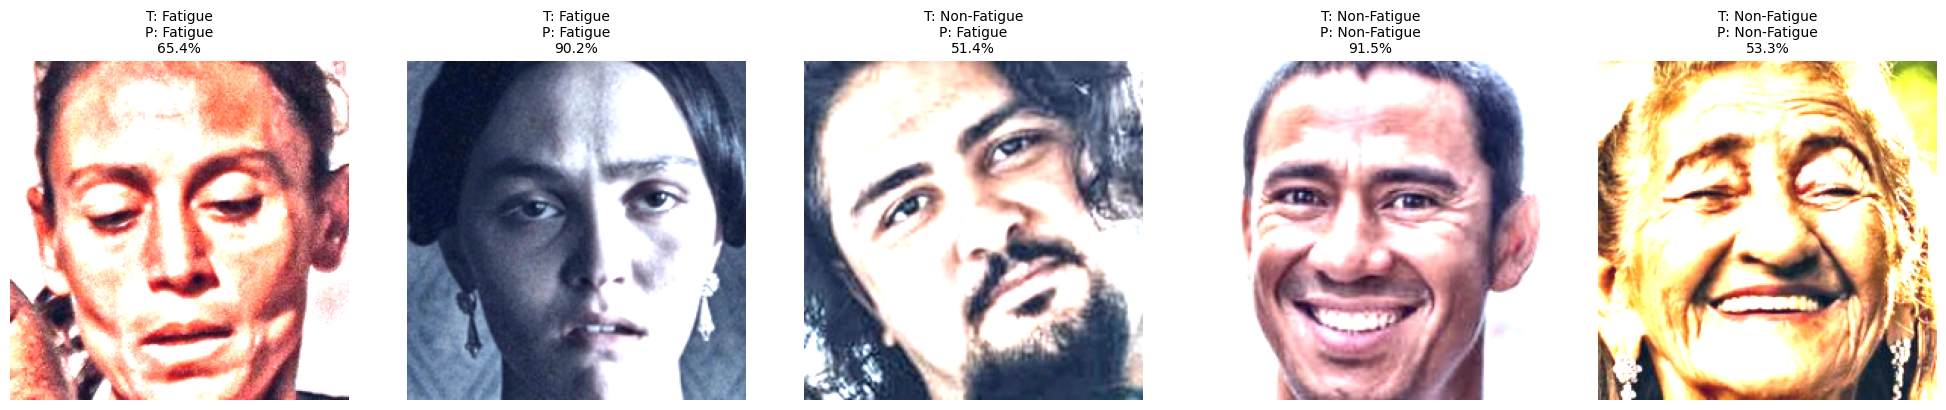

Showing 5 sample predictions for CustomCNN...


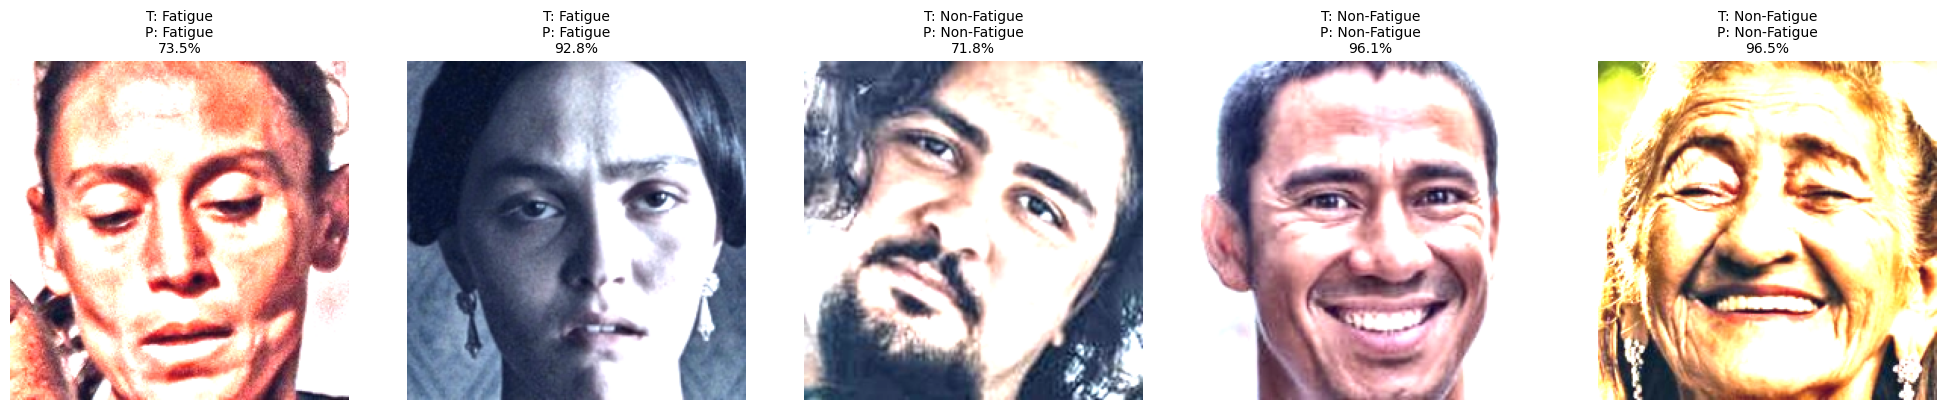

In [11]:
import numpy as np
def show_sample_predictions(model, dataloader, device, num_images=5):
    model.eval()
    print(f"Showing {num_images} sample predictions for {model.__class__.__name__}...")
    # Get a single batch
    inputs, labels = next(iter(dataloader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    # Show 5 images in a row
    plt.figure(figsize=(20, 4))

    for i in range(num_images):

        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max())  # normalize for display
        img = np.clip(img, 0, 1)  # clip values to [0, 1]
        true_label = "Fatigue" if labels[i].item() == 0 else "Non-Fatigue"
        pred_label = "Fatigue" if preds[i].item() == 0 else "Non-Fatigue"

        confidence = probs[i][preds[i]].item() * 100

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"T: {true_label}\nP: {pred_label}\n{confidence:.1f}%",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

for model in model_list:
    show_sample_predictions(model, test_loader, device)

Visualizing Saliency for ResNet...


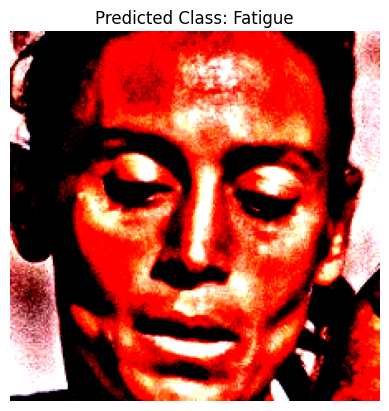

Visualizing Saliency for VGG...


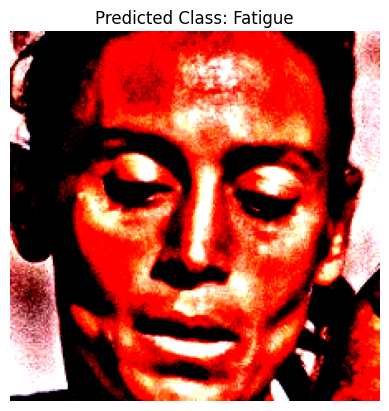

Visualizing Saliency for MobileNetV2...


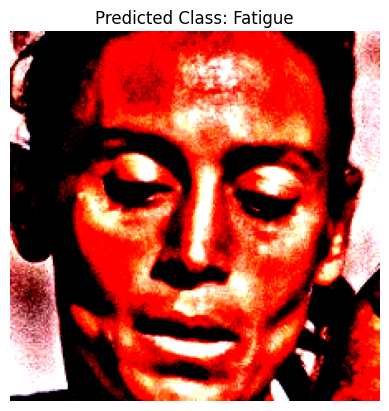

Visualizing Saliency for CustomCNN...


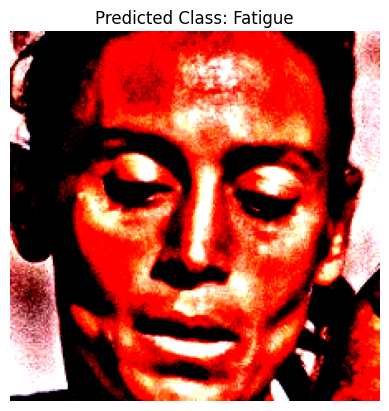

In [14]:
def visualize_saliency(model, image_tensor):

    model.eval()
    image_tensor = image_tensor.clone().detach().requires_grad_(True)

    output = model(image_tensor)
    pred_class = output.argmax(dim=1)

    # Backprop for the predicted class
    output[0, pred_class].backward()

    saliency, _ = torch.max(image_tensor.grad.data.abs().cpu(), dim=1)  # max across channels
    plt.imshow(saliency[0], cmap='hot')
    # show image
    img_display = image_tensor.cpu().squeeze(0).permute(1, 2, 0).detach().numpy()
    np.clip(img_display, 0, 1)
    plt.imshow(img_display)
    predicted = "Fatigue" if pred_class.item() == 0 else "Non-Fatigue"
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted}")
    plt.show()


image_tensor = next(iter(test_loader))[0][0].unsqueeze(0).to(device)
for model in model_list:
    print(f"Visualizing Saliency for {model.__class__.__name__}...")
    visualize_saliency(model, image_tensor=image_tensor)